In [ ]:
import pandas as pd

# Load data
data = pd.read_csv('D://OpenAQtask/pm25data.csv')
data.head()

In [ ]:
datechange = pd.to_datetime(data['datetime'])
data = data.sort_values(by='datetime')

# Optionally, set 'datetime' as index if needed
data.set_index('datetime')


In [ ]:
data

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Ensure the index is a datetime type
data.index = pd.to_datetime(data.index)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(data[['value']])

# Calculate split points for 80-10-10 ratio
total_rows = len(data)
train_end = int(total_rows * 0.8)
val_end = int(total_rows * 0.9)

# Split data
train_data = scaled_values[:train_end]
val_data = scaled_values[train_end:val_end]
test_data = scaled_values[val_end:]


# Prepare data for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 24  # Example: using 24 hours of data to predict the next value
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(time_step, 1))),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Forecasting function
def forecast(model, input_data, time_step):
    forecast = []
    input_seq = input_data[0]  # Start with the first sequence
    for _ in range(len(input_data)):
        x = input_seq.reshape((1, time_step, 1))
        y_hat = model.predict(x, verbose=0)
        forecast.append(y_hat[0, 0])
        input_seq = np.append(input_seq[1:], y_hat, axis=0)
    return np.array(forecast)

# Forecast on test data
test_forecast = forecast(model, X_test, time_step)
test_forecast = scaler.inverse_transform(test_forecast.reshape(-1, 1))

# Calculate MSE
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mse = mean_squared_error(y_test, test_forecast)
print(f'Test Mean Squared Error: {test_mse}')


Epoch 1/50
181/181 [==============================] - 14s 36ms/step - loss: 0.0152 - val_loss: 0.0190
Epoch 2/50
181/181 [==============================] - 5s 25ms/step - loss: 0.0110 - val_loss: 0.0176
Epoch 3/50
181/181 [==============================] - 4s 22ms/step - loss: 0.0097 - val_loss: 0.0165
Epoch 4/50
181/181 [==============================] - 4s 22ms/step - loss: 0.0096 - val_loss: 0.0174
Epoch 5/50
181/181 [==============================] - 4s 22ms/step - loss: 0.0092 - val_loss: 0.0162
Epoch 6/50
181/181 [==============================] - 4s 22ms/step - loss: 0.0091 - val_loss: 0.0160
Epoch 7/50
181/181 [==============================] - 4s 23ms/step - loss: 0.0089 - val_loss: 0.0157
Epoch 8/50
181/181 [==============================] - 4s 23ms/step - loss: 0.0085 - val_loss: 0.0153
Epoch 9/50
181/181 [==============================] - 4s 23ms/step - loss: 0.0085 - val_loss: 0.0156
Epoch 10/50
181/181 [==============================] - 4s 24ms/step - loss: 0.0087 - val_l

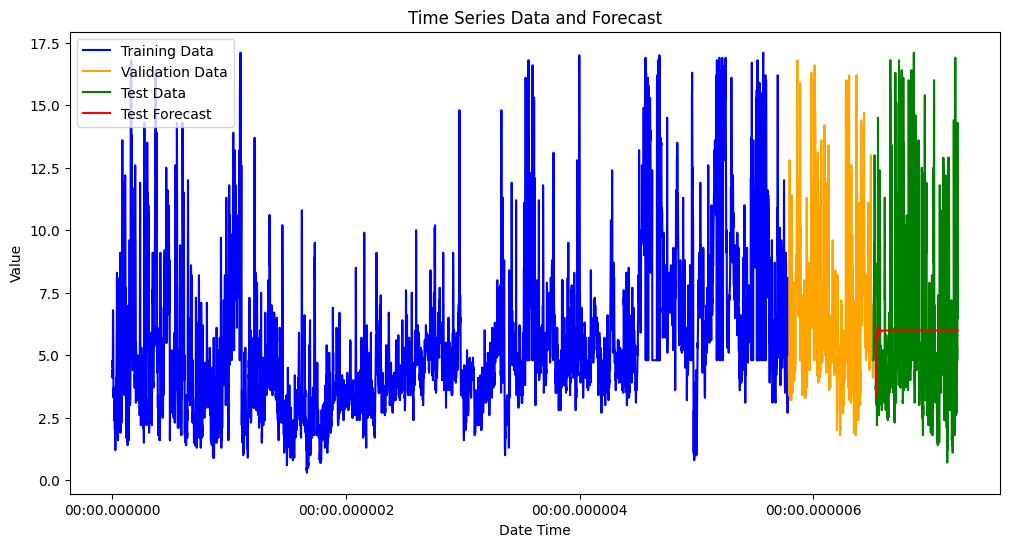

In [52]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot Training Data
plt.plot(data.index[:train_end], scaler.inverse_transform(train_data).flatten(), label='Training Data', color='blue')

# Plot Validation Data
plt.plot(data.index[train_end:val_end], scaler.inverse_transform(val_data).flatten(), label='Validation Data', color='orange')

# Plot Test Data
plt.plot(data.index[val_end:], scaler.inverse_transform(test_data).flatten(), label='Test Data', color='green')

# Plot Forecast
forecast_index = data.index[val_end + time_step:val_end + time_step + len(test_forecast)]
plt.plot(forecast_index, test_forecast.flatten(), label='Test Forecast', color='red')

# Add title and labels
plt.title('Time Series Data and Forecast')
plt.xlabel('Date Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [55]:
model.save('D://OpenAQtask/lstm_model.h5')

1/1 [==============================] - 0s 20ms/step


C:\Users\hassan\AppData\Local\Temp\ipykernel_16084\3387486509.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_forecast_index = pd.date_range(start=future_start_date, periods=number_of_future_steps, freq='H')


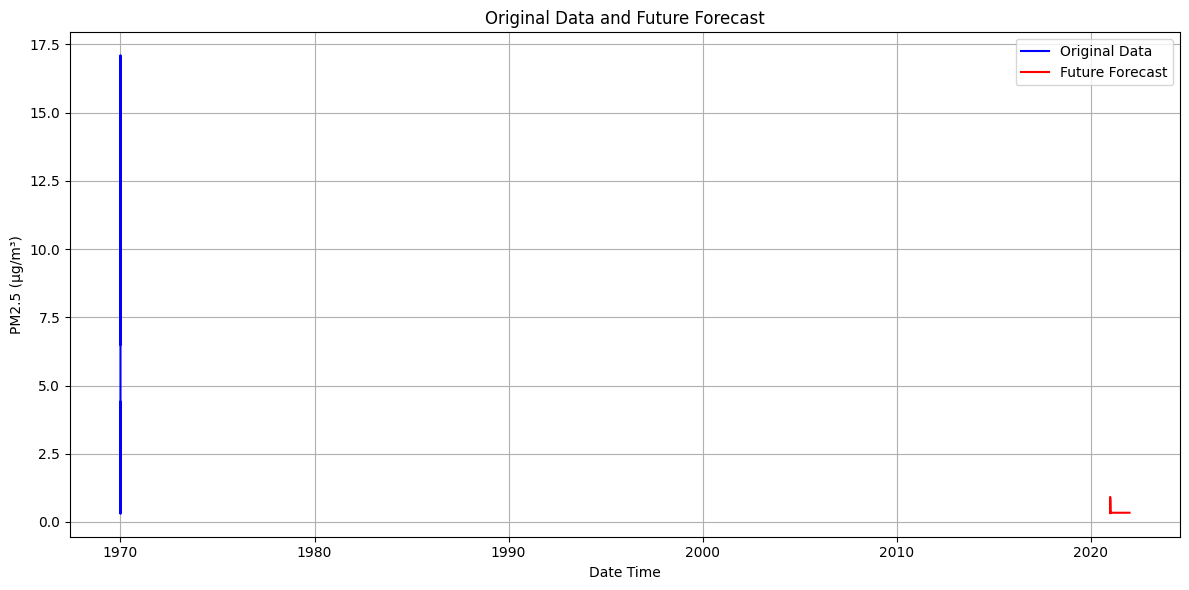

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming the LSTM model is already trained and saved as 'lstm_model.h5'
model = load_model('D://OpenAQtask/lstm_model.h5')

# Define the future dates
future_start_date = pd.to_datetime('2021-01-01')
future_end_date = pd.to_datetime('2022-01-01')
number_of_future_steps = int((future_end_date - future_start_date).total_seconds() / 3600)  # For hourly data

# Prepare the last known data point as input for future prediction
last_known_data = data['value'].values[-model.input_shape[1]:]
input_seq = last_known_data.reshape(1, model.input_shape[1], 1)  # Reshape for LSTM model

# Generate future forecast
future_forecast = []
for _ in range(number_of_future_steps):
    predicted_value = model.predict(input_seq)[0, 0]
    future_forecast.append(predicted_value)
    # Reshape the predicted value to match input_seq shape
    predicted_value_reshaped = np.array(predicted_value).reshape(1, 1, 1)
    input_seq = np.append(input_seq[:, 1:, :], predicted_value_reshaped, axis=1)

# Create future forecast index
future_forecast_index = pd.date_range(start=future_start_date, periods=number_of_future_steps, freq='H')

# Plot future forecast along with original data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Original Data', color='blue')
plt.plot(future_forecast_index, future_forecast, label='Future Forecast', color='red')
plt.xlabel('Date Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Original Data and Future Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
